# Multi-Modal Health Risk Prediction Model

This notebook demonstrates the multi-modal fusion model that combines predictions from all three individual models.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings

# Add src to path
sys.path.append(str(Path().absolute().parent / "src"))

from models.multimodal_model import MultiModalHealthRiskModel

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

print("Libraries imported successfully!")


Libraries imported successfully!


## Load Data from All Three Sources


In [2]:
# Load data from all three sources
data_dir = Path().absolute().parent / "data" / "raw"
models_dir = Path().absolute().parent / "models"

df_wearable = pd.read_csv(data_dir / "wearable_data.csv", parse_dates=['timestamp'])
df_air_quality = pd.read_csv(data_dir / "air_quality_data.csv", parse_dates=['timestamp'])
df_weather = pd.read_csv(data_dir / "weather_data.csv", parse_dates=['timestamp'])

print(f"✓ Loaded wearable data: {len(df_wearable)} records")
print(f"✓ Loaded air quality data: {len(df_air_quality)} records")
print(f"✓ Loaded weather data: {len(df_weather)} records")

print(f"\nWearable data shape: {df_wearable.shape}")
print(f"Air quality data shape: {df_air_quality.shape}")
print(f"Weather data shape: {df_weather.shape}")


✓ Loaded wearable data: 3000 records
✓ Loaded air quality data: 150 records
✓ Loaded weather data: 150 records

Wearable data shape: (3000, 10)
Air quality data shape: (150, 11)
Weather data shape: (150, 10)


## Initialize Multi-Modal Model


In [3]:
# Initialize multi-modal model with ensemble strategy
multimodal_model = MultiModalHealthRiskModel(strategy='ensemble')

# Load the trained individual models
print("Loading individual models...")
multimodal_model.load_individual_models(models_dir)
print("\n✓ All models loaded successfully!")


Loading individual models...
✓ Loaded wearable model from /Users/faiqahmed/Desktop/Semesters/Semester7/MLOPS/PROJECT/models/wearable_model_gradient_boosting.pkl
✓ Loaded air quality model from /Users/faiqahmed/Desktop/Semesters/Semester7/MLOPS/PROJECT/models/air_quality_model_random_forest.pkl
✓ Loaded weather model from /Users/faiqahmed/Desktop/Semesters/Semester7/MLOPS/PROJECT/models/weather_model_gradient_boosting.pkl

✓ All models loaded successfully!


## Make Predictions Using Multi-Modal Model


In [4]:
# Prepare sample data for prediction
# Using a subset of data that has temporal alignment
sample_size = min(30, len(df_wearable), len(df_air_quality), len(df_weather))

df_wearable_sample = df_wearable.head(sample_size).copy()
df_air_quality_sample = df_air_quality.head(sample_size).copy()
df_weather_sample = df_weather.head(sample_size).copy()

# Make predictions using multi-modal model
print("Making predictions with multi-modal model...")
predictions, probabilities = multimodal_model.predict(
    df_wearable=df_wearable_sample,
    df_air_quality=df_air_quality_sample,
    df_weather=df_weather_sample
)

print(f"\n✓ Generated {len(predictions)} multi-modal predictions")
print(f"\nPrediction distribution:")
unique, counts = np.unique(predictions, return_counts=True)
for pred, count in zip(unique, counts):
    print(f"  {pred}: {count} ({count/len(predictions)*100:.1f}%)")


Making predictions with multi-modal model...

✓ Generated 30 multi-modal predictions

Prediction distribution:
  low: 30 (100.0%)


## Visualize Predictions


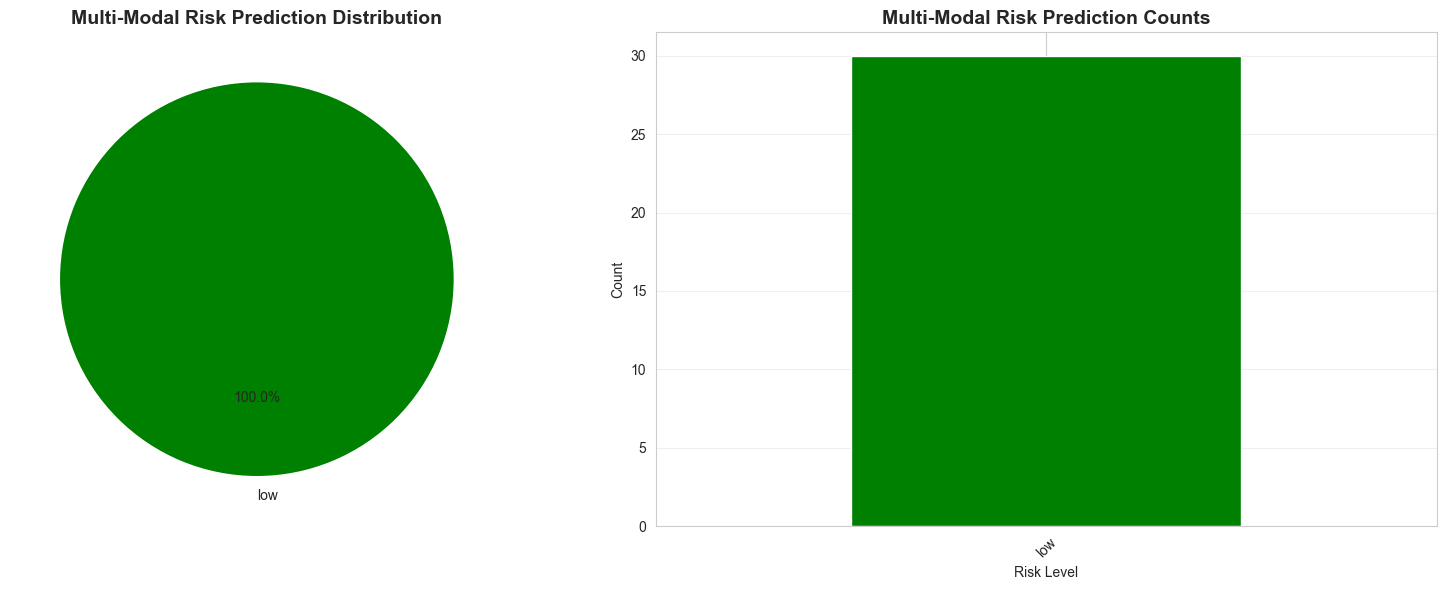

In [5]:
# Create visualization of prediction distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart
pred_counts = pd.Series(predictions).value_counts()
colors_map = {'low': 'green', 'moderate': 'orange', 'high': 'red'}
colors = [colors_map.get(pred, 'gray') for pred in pred_counts.index]

axes[0].pie(pred_counts.values, labels=pred_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
axes[0].set_title('Multi-Modal Risk Prediction Distribution', fontweight='bold', fontsize=14)

# Bar chart
pred_counts.plot(kind='bar', ax=axes[1], color=[colors_map.get(pred, 'gray') for pred in pred_counts.index])
axes[1].set_title('Multi-Modal Risk Prediction Counts', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Risk Level')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## Compare Individual vs Multi-Modal Predictions


In [6]:
# Get individual model predictions for comparison
if multimodal_model.wearable_model:
    wearable_preds, _ = multimodal_model.wearable_model.predict(df_wearable_sample)
    print("Wearable Model Predictions:")
    print(pd.Series(wearable_preds).value_counts())
    print()

if multimodal_model.air_quality_model:
    air_preds, _ = multimodal_model.air_quality_model.predict(df_air_quality_sample)
    print("Air Quality Model Predictions:")
    print(pd.Series(air_preds).value_counts())
    print()

if multimodal_model.weather_model:
    weather_preds, _ = multimodal_model.weather_model.predict(df_weather_sample)
    print("Weather Model Predictions:")
    print(pd.Series(weather_preds).value_counts())
    print()

print("Multi-Modal Model Predictions:")
print(pd.Series(predictions).value_counts())


Wearable Model Predictions:
normal    30
Name: count, dtype: int64

Air Quality Model Predictions:
good        15
moderate    15
Name: count, dtype: int64

Weather Model Predictions:
moderate    15
low         11
high         4
Name: count, dtype: int64

Multi-Modal Model Predictions:
low    30
Name: count, dtype: int64


## Prediction Probabilities


Prediction Probabilities (first 10 samples):
        low  moderate      high prediction
0  0.353954  0.341710  0.304336        low
1  0.055589  0.330152  0.614260        low
2  0.025930  0.660594  0.313476        low
3  0.328457  0.008246  0.663297        low
4  0.005261  0.330683  0.664056        low
5  0.330480  0.003568  0.665953        low
6  0.057867  0.286508  0.651736        low
7  0.004831  0.664014  0.331154        low
8  0.004786  0.666690  0.328524        low
9  0.403245  0.000817  0.595939        low


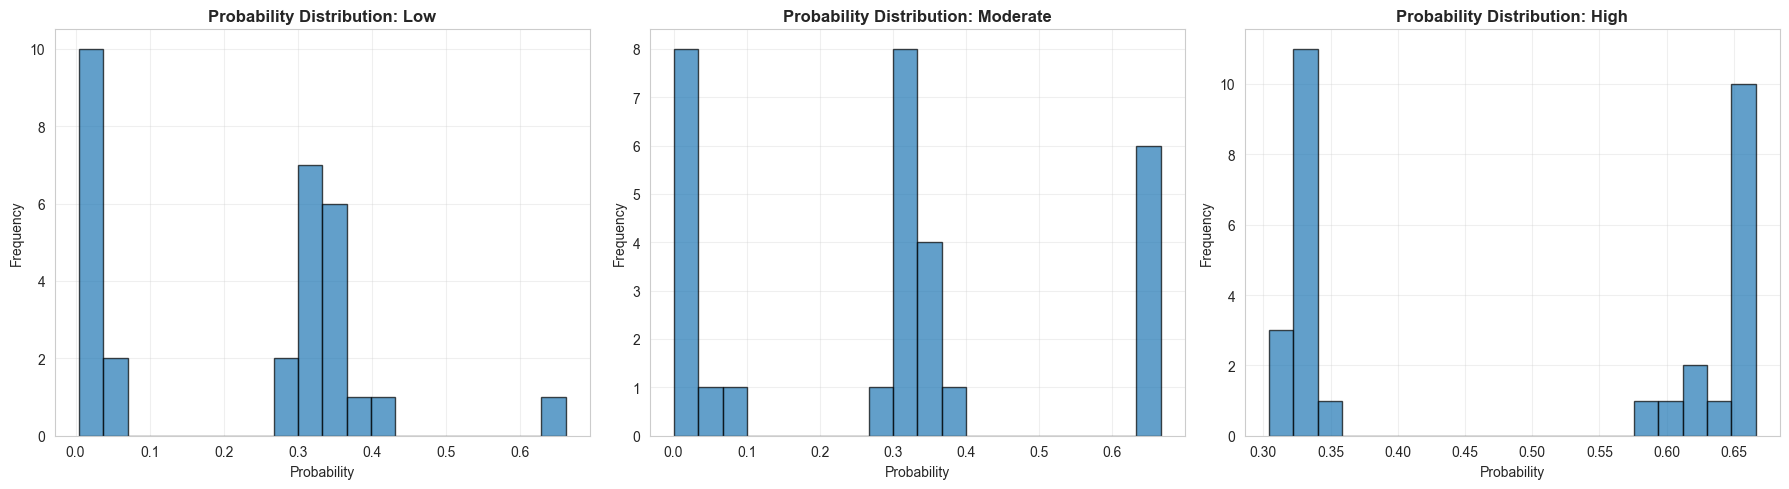

In [7]:
# Display prediction probabilities for first few samples
prob_df = pd.DataFrame(probabilities, columns=['low', 'moderate', 'high'])
prob_df['prediction'] = predictions

print("Prediction Probabilities (first 10 samples):")
print(prob_df.head(10).to_string())

# Visualize probability distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, risk_level in enumerate(['low', 'moderate', 'high']):
    axes[idx].hist(probabilities[:, idx], bins=20, alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'Probability Distribution: {risk_level.title()}', fontweight='bold')
    axes[idx].set_xlabel('Probability')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## Test Weighted Average Strategy


In [8]:
# Try weighted average strategy with custom weights
multimodal_weighted = MultiModalHealthRiskModel(strategy='weighted_average')
multimodal_weighted.load_individual_models(models_dir)

# Custom weights: wearable=50%, air_quality=30%, weather=20%
custom_weights = {
    'wearable': 0.5,
    'air_quality': 0.3,
    'weather': 0.2
}

predictions_weighted, probabilities_weighted = multimodal_weighted.predict(
    df_wearable=df_wearable_sample,
    df_air_quality=df_air_quality_sample,
    df_weather=df_weather_sample,
    weights=custom_weights
)

print("Weighted Average Strategy Results:")
print(f"\nPrediction distribution:")
unique, counts = np.unique(predictions_weighted, return_counts=True)
for pred, count in zip(unique, counts):
    print(f"  {pred}: {count} ({count/len(predictions_weighted)*100:.1f}%)")

# Compare strategies
comparison_df = pd.DataFrame({
    'Ensemble': pd.Series(predictions).value_counts(),
    'Weighted Average': pd.Series(predictions_weighted).value_counts()
}).fillna(0)

print("\nComparison of Strategies:")
print(comparison_df)


✓ Loaded wearable model from /Users/faiqahmed/Desktop/Semesters/Semester7/MLOPS/PROJECT/models/wearable_model_gradient_boosting.pkl
✓ Loaded air quality model from /Users/faiqahmed/Desktop/Semesters/Semester7/MLOPS/PROJECT/models/air_quality_model_random_forest.pkl
✓ Loaded weather model from /Users/faiqahmed/Desktop/Semesters/Semester7/MLOPS/PROJECT/models/weather_model_gradient_boosting.pkl
Weighted Average Strategy Results:

Prediction distribution:
  high: 25 (83.3%)
  moderate: 5 (16.7%)

Comparison of Strategies:
          Ensemble  Weighted Average
high           0.0              25.0
low           30.0               0.0
moderate       0.0               5.0


## Summary

This notebook demonstrates:
1. ✅ Loading all three individual models
2. ✅ Combining predictions using multi-modal fusion
3. ✅ Two fusion strategies: Ensemble voting and Weighted average
4. ✅ Visualization of predictions and probabilities
5. ✅ Comparison between individual and multi-modal predictions

**Key Insights:**
- Multi-modal model provides more robust predictions by combining multiple data sources
- Ensemble voting uses majority vote across models
- Weighted average allows customization based on data source reliability
- Risk levels are normalized to a common scale (low, moderate, high)
